<a href="https://colab.research.google.com/github/maanjum95/Traffic-Sign-Detection/blob/master/traffic_sign_classifier_custom_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
import time
import sys

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers


# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot

In [2]:
#mount google drive
drive.mount('/content/drive')

# download the data and upload to Gdrive
# IMPORTANT: IF RUNNING FOR THE VERY FIRST TIME UNCOMMENT THE LINES BELOW
# DOWNLOADS THE DATA TO GOOGLE DRIVE 
# !wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
# !cp traffic-signs-data.zip /content/drive/MyDrive/gtsrb

# copy and unzip the dataset
!cp /content/drive/MyDrive/gtsrb/traffic-signs-data.zip .
!unzip -o traffic-signs-data.zip -d traffic-signs-data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  traffic-signs-data.zip
  inflating: traffic-signs-data/test.p  
  inflating: traffic-signs-data/train.p  
  inflating: traffic-signs-data/valid.p  


In [3]:
# load data
training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pkl.load(f)
with open(validation_file, mode='rb') as f:
    valid = pkl.load(f)
with open(testing_file, mode='rb') as f:
    test = pkl.load(f)

In [4]:
IMG_WIDTH = 32
IMG_HEIGHT = 32

X_train = train["features"]
y_train = train["labels"]

X_valid = valid["features"]
y_valid = valid["labels"]

X_test = test["features"]
y_test = test["labels"]

print(f"Number of training: {y_train.shape}")
print(f"Number of valid: {y_valid.shape}")
print(f"Number of test: {y_test.shape}")

Number of training: (34799,)
Number of valid: (4410,)
Number of test: (12630,)


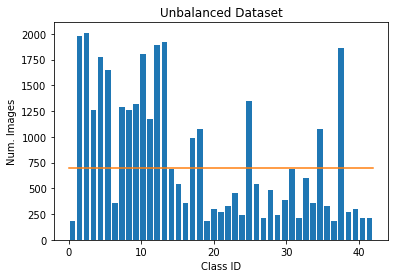

Average bin size: 809.2790697674419
Minimum bin size: 180
Maximum bin size: 2010
Above 700 bin size: 17
Below 700 bin size: 26


In [5]:
# dataset statistics

num_bins = 43
samples_per_bin = 700
plt.hist(y_train, bins=num_bins, rwidth=0.8)
plt.plot((np.min(y_train), np.max(y_train)), (samples_per_bin, samples_per_bin))
plt.title("Unbalanced Dataset")
plt.xlabel("Class ID")
plt.ylabel("Num. Images")
plt.show()

hist, bins = np.histogram(y_train, num_bins)

print(f"Average bin size: {np.mean(hist)}")
print(f"Minimum bin size: {np.min(hist)}")
print(f"Maximum bin size: {np.max(hist)}")
print(f"Above {samples_per_bin} bin size: {(hist > samples_per_bin).sum()}")
print(f"Below {samples_per_bin} bin size: {(hist <= samples_per_bin).sum()}")

In [6]:
print(hist)

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


In [7]:
# Balancing the dataset
# Dataset is highly skewed
before_balance = len(y_train)
print(f"Dataset before balancing {len(y_train)}")

idx_arr = []
for _id in range(num_bins):
    id_idxs = np.where(y_train == _id)[0]
    if len(id_idxs) > samples_per_bin:
        id_idxs = np.random.choice(id_idxs, samples_per_bin, replace=False)
    idx_arr.append(id_idxs)
id_mask = np.hstack(idx_arr)

X_train = X_train[id_mask]
y_train = y_train[id_mask]
print(f"Dataset after balancing: {len(y_train)}")
print(f"Dataset removed: {before_balance - len(y_train)}")

Dataset before balancing 34799
Dataset after balancing: 21019
Dataset removed: 13780


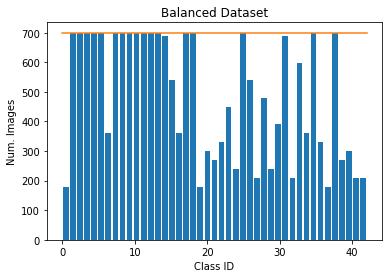

Average bin size: 488.8139534883721
Minimum bin size: 180
Maximum bin size: 700
Above 700 bin size: 0
Below 700 bin size: 43


In [8]:
# dataset statistics

plt.hist(y_train, bins=num_bins, rwidth=0.8)
plt.plot((np.min(y_train), np.max(y_train)), (samples_per_bin, samples_per_bin))
plt.title("Balanced Dataset")
plt.xlabel("Class ID")
plt.ylabel("Num. Images")
plt.show()

hist, bins = np.histogram(y_train, num_bins)

print(f"Average bin size: {np.mean(hist)}")
print(f"Minimum bin size: {np.min(hist)}")
print(f"Maximum bin size: {np.max(hist)}")
print(f"Above {samples_per_bin} bin size: {(hist > samples_per_bin).sum()}")
print(f"Below {samples_per_bin} bin size: {(hist <= samples_per_bin).sum()}")

In [9]:
# Model definition
model = tf.keras.Sequential([
    layers.Conv2D(24, (5, 5), strides=(1, 1), 
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), activation="relu"),
    layers.Conv2D(36, (5, 5), strides=(1, 1),
        activation="relu"),
    layers.Conv2D(48, (5, 5), strides=(1, 1),
        activation="relu"),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(250, activation="relu"),
    layers.Dense(125, activation="relu"),
    layers.Dense(75, activation="relu"),
    layers.Dense(43, activation="softmax")
])

In [10]:
# Image Augmentation
# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )
# Data augmentation
# data_augmentation = tf.keras.Sequential([
#     layers.RandomContrast(0.5),
#     layers.RandomRotation(0.03),
#     layers.RandomTranslation(0.05, 0.05),
#     layers.RandomZoom((-0.1, 0.3))                                   
# ])
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    brightness_range=(0.2, 1.2), shear_range=0.2, zoom_range=[0.7, 1.3],
    )
it = datagen.flow(X_train, y_train)

# random_transform(
#     x, seed=None
# )

In [11]:
# Model compilation
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
#model.build((None, IMG_WIDTH, IMG_HEIGHT, 3))

# Model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 250)               4

In [12]:
# Fitting the model
# Self defined models
# history = model.fit(x=X_train, y=y_train, 
#                     batch_size=32, 
#                     epochs=1, 
#                     verbose=1, 
#                     validation_data=(X_valid, y_valid))

# Data augmentation out of model
# Incase of pre existing models
# history = model.fit(train_ds, 
#                     batch_size=32, 
#                     epochs=1, 
#                     verbose=1, 
#                     validation_data=valid_ds)

history = model.fit(it, epochs=14, batch_size=32, verbose=1, validation_data=(X_valid, y_valid))


Epoch 1/14
657/657 [==============================] - 24s 28ms/step - loss: 2.6690 - accuracy: 0.3356 - val_loss: 1.7893 - val_accuracy: 0.5308
Epoch 2/14
657/657 [==============================] - 17s 26ms/step - loss: 1.4017 - accuracy: 0.6218 - val_loss: 1.1476 - val_accuracy: 0.7270
Epoch 3/14
657/657 [==============================] - 17s 27ms/step - loss: 0.8874 - accuracy: 0.7629 - val_loss: 0.9100 - val_accuracy: 0.7671
Epoch 4/14
657/657 [==============================] - 18s 27ms/step - loss: 0.6211 - accuracy: 0.8424 - val_loss: 0.6280 - val_accuracy: 0.8687
Epoch 5/14
657/657 [==============================] - 17s 27ms/step - loss: 0.4776 - accuracy: 0.8796 - val_loss: 0.5231 - val_accuracy: 0.8875
Epoch 6/14
657/657 [==============================] - 17s 26ms/step - loss: 0.3904 - accuracy: 0.9026 - val_loss: 0.4341 - val_accuracy: 0.9122
Epoch 7/14
657/657 [==============================] - 17s 26ms/step - loss: 0.3260 - accuracy: 0.9207 - val_loss: 0.5884 - val_accuracy:

Text(0.5, 0, 'epoch')

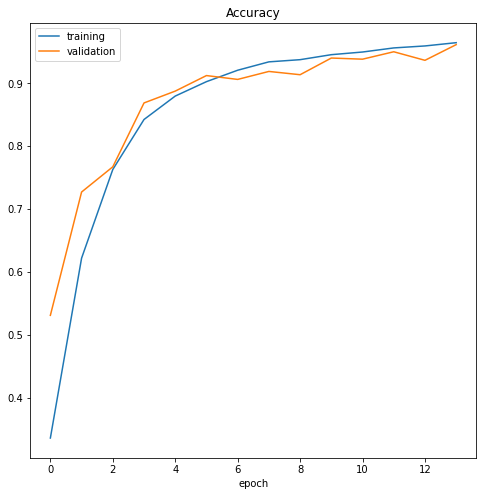

In [13]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

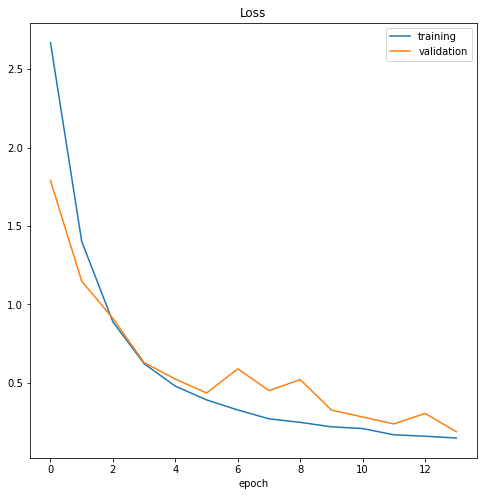

In [14]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

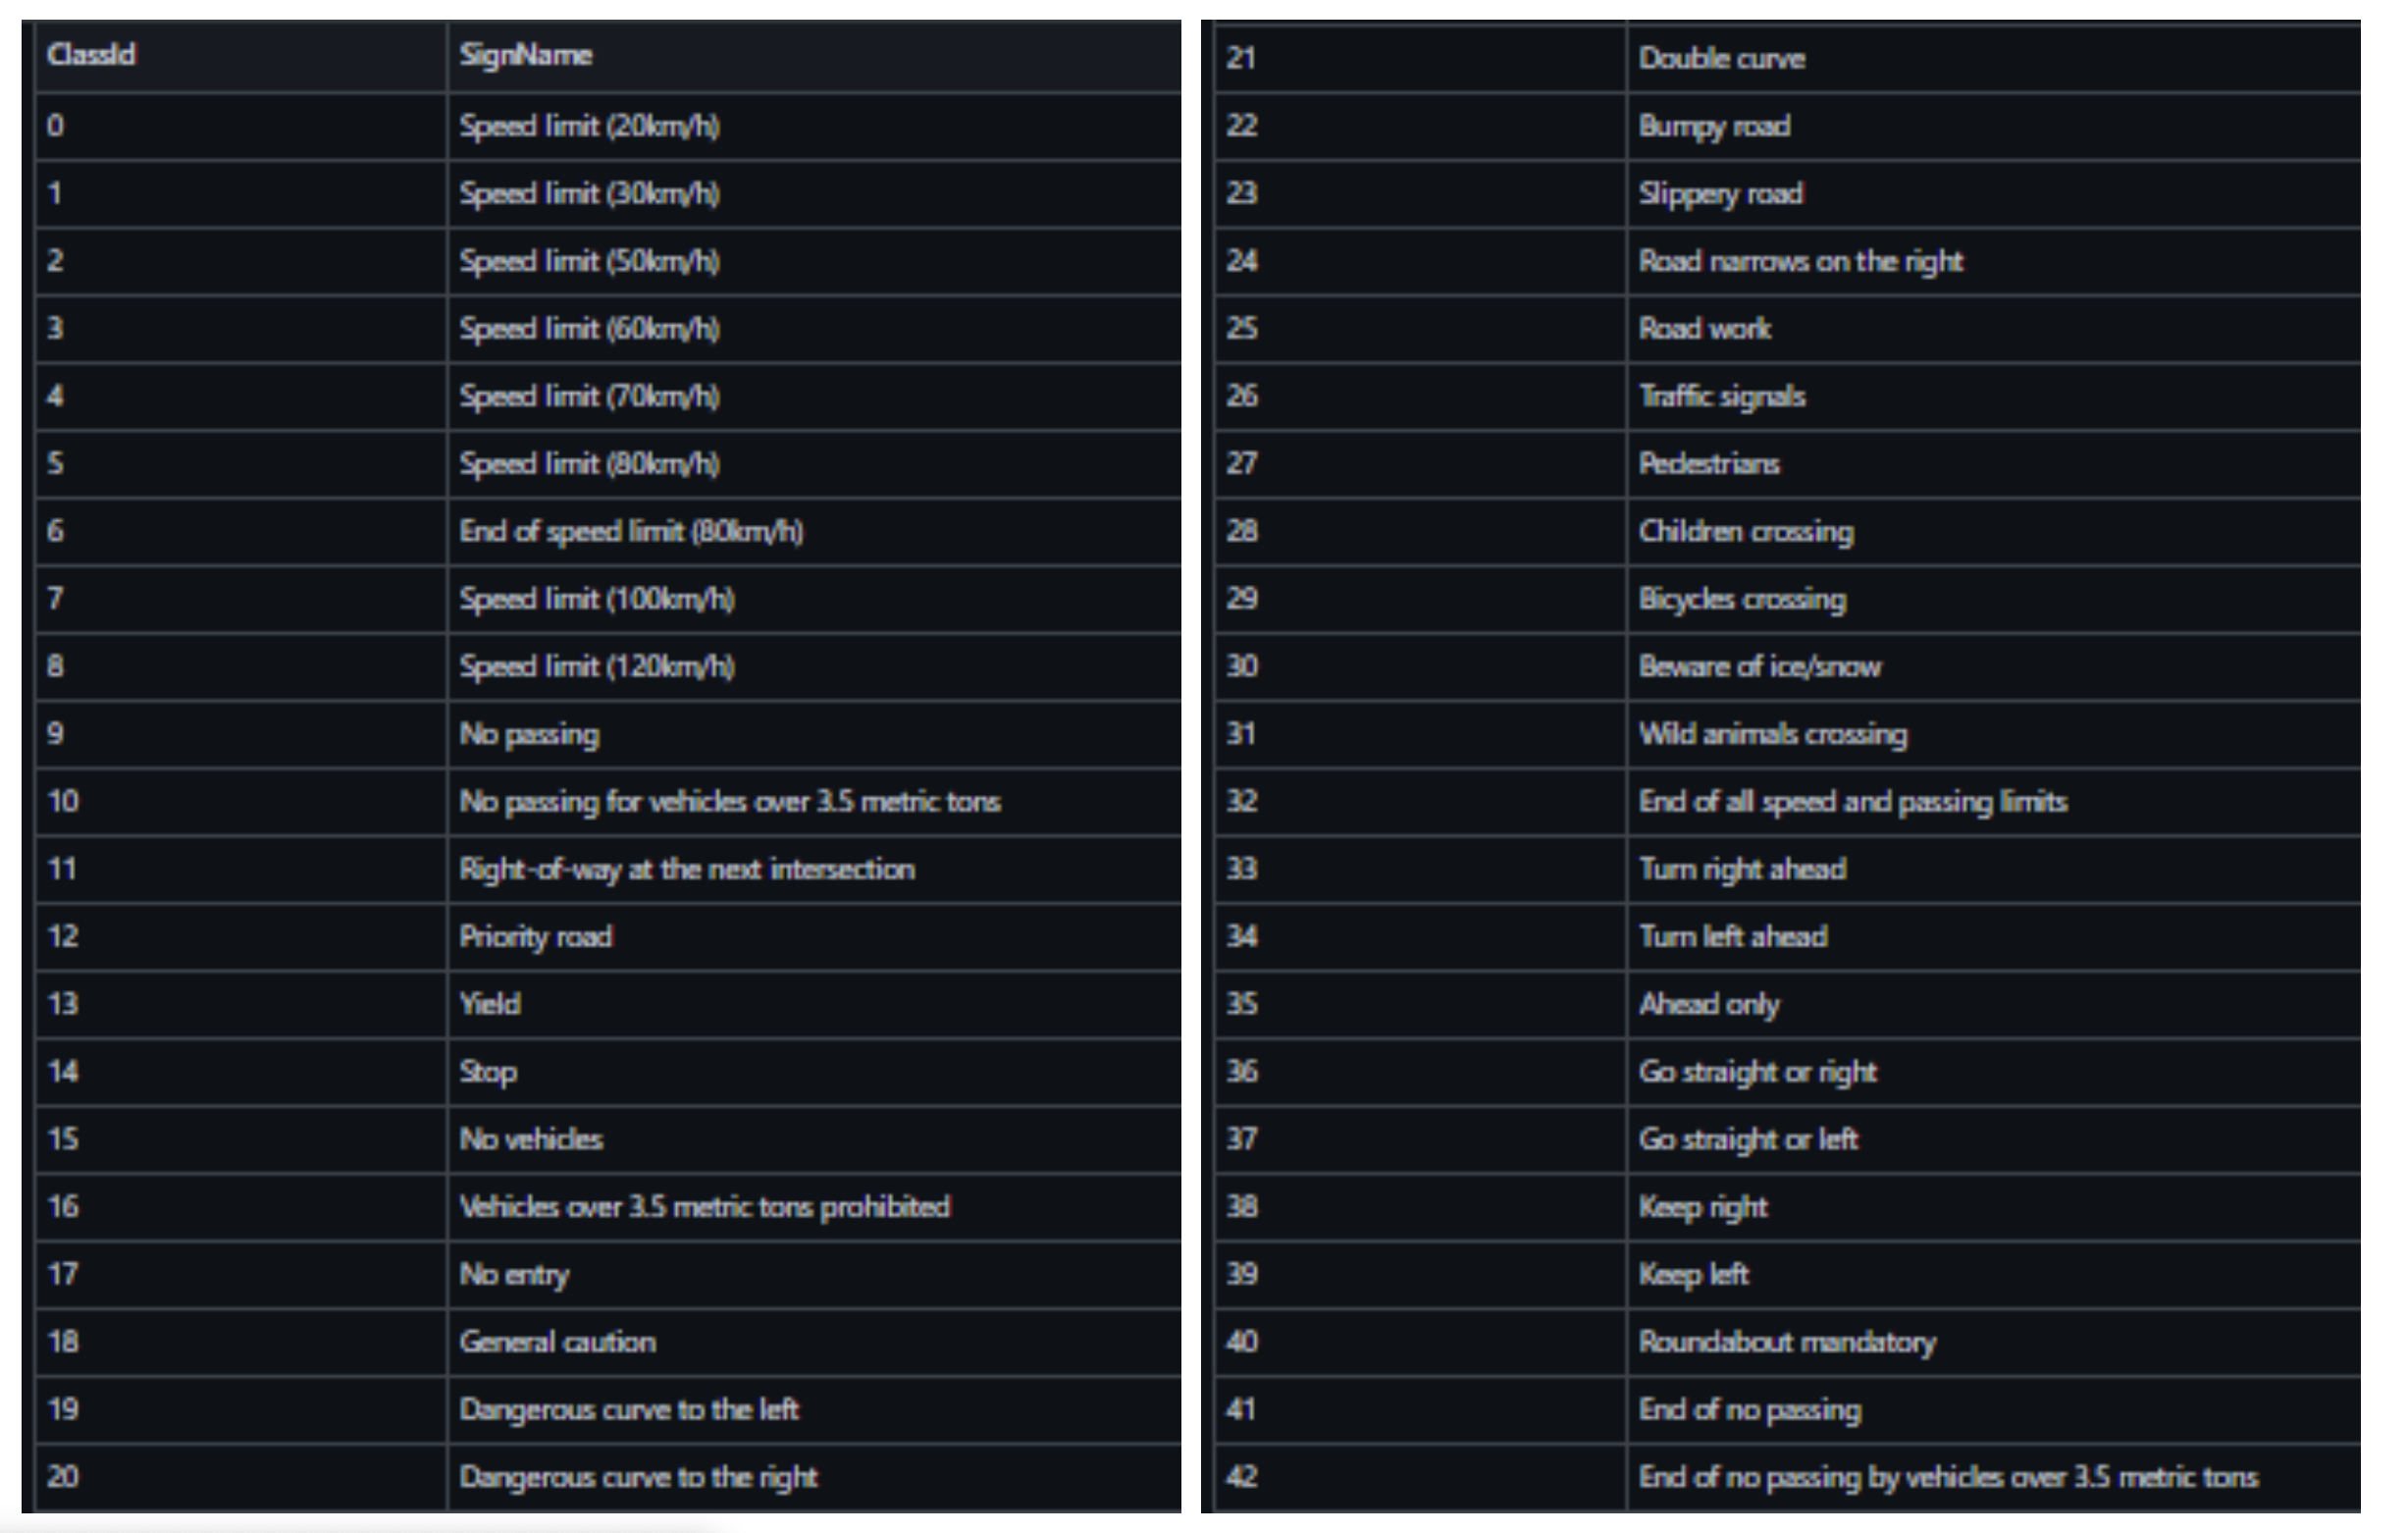

Actual:  1
[[1.1797636e-02 9.8636603e-01 8.6608267e-09 2.9414976e-17 1.8323271e-03
  1.8200921e-09 7.4985740e-11 1.7603219e-06 2.2415641e-06 2.8266207e-17
  1.7535713e-15 2.0027742e-12 1.8392246e-26 2.0993176e-16 2.2238026e-11
  3.1972400e-19 3.6457542e-11 1.7397638e-17 8.2253078e-18 4.6766855e-13
  1.0914781e-16 2.1450595e-12 1.9149953e-18 1.9925055e-16 1.1616211e-14
  3.8152910e-12 6.6858015e-18 1.0801353e-12 2.0994918e-14 5.2783434e-14
  1.1589349e-13 7.5582761e-12 8.1733648e-12 3.2578738e-20 3.0214016e-17
  1.3472192e-17 8.6074478e-14 2.9615680e-20 8.1852763e-10 1.8988804e-13
  2.1175248e-14 4.4715179e-11 7.5982894e-11]]
Prediction:  1
Prediction took: 0.3101ms


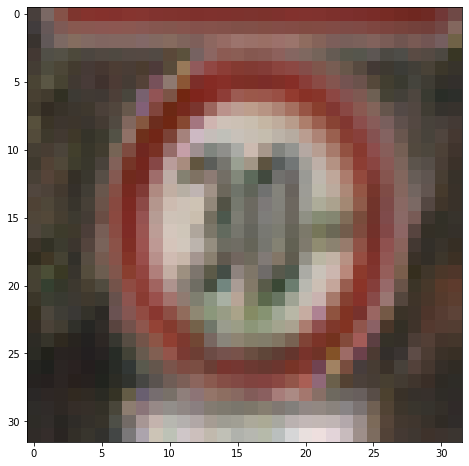

In [15]:
index = random.randint(0,len(X_test)-1)
img_testing = X_test[index]
label_testing = y_test[index]

plt.imshow(img_testing)
print ("Actual: ", label_testing)
img_testing = img_testing.reshape(-1, IMG_WIDTH, IMG_HEIGHT,3)

start_time = time.time()
print(model.predict(img_testing))
print ("Prediction: ", np.argmax(model.predict(img_testing)))
time_taken = time.time() - start_time
print(f"Prediction took: {round(time_taken, 4)}ms")

In [16]:
# Average time per image
time_taken = 0.0
for _ in range(100):
    index = random.randint(0,len(X_test)-1)
    img_testing = X_test[index]
    label_testing = y_test[index]

    img_testing = img_testing.reshape(-1, IMG_WIDTH, IMG_HEIGHT,3)

    start_time = time.time_ns()
    prediction = np.argmax(model.predict(img_testing))
    time_taken += (time.time_ns() - start_time) / 10**6
print(f"Prediction took on avg: {round(time_taken / 100, 4)}ms")

Prediction took on avg: 39.3006ms


In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
395/395 [==============================] - 2s 4ms/step - loss: 0.3076 - accuracy: 0.9427
test loss, test acc: [0.30759912729263306, 0.9426761865615845]


In [18]:
# Save the model
model.save('traffic_custom_dnn.h5')